<a href="https://colab.research.google.com/github/SHodapp117/Portfolio-/blob/main/Statsbomb_Spain_Passing_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kloppy
!pip install statsbombpy
!pip install mplsoccer
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.patches import FancyArrowPatch
from mplsoccer.pitch import VerticalPitch
import matplotlib as mpl
from mplsoccer import FontManager
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'Palatino Linotype'
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter

In [2]:
sb.competitions()
euro_20 = sb.matches(competition_id=55, season_id=43)

MATCH_id = 3795108
match_events_df = sb.events(match_id=MATCH_id)

match_360_df = pd.read_json('/content/3795108.json')
match_360_df.head()

,event_uuid,visible_area,freeze_frame
0,ea57ee78-a4ef-4d62-81c7-98cdf1c11925,"[120.0, 80.0, 0.0, 80.0, 0.0, 77.9359903100536...","[{'teammate': True, 'actor': False, 'keeper': ..."
1,66655fd3-2764-4532-b1bb-0a01074fed30,"[0.0, 80.0, 0.0, 68.3780973203674, 35.45516025...","[{'teammate': True, 'actor': True, 'keeper': F..."
2,3765b81d-d184-4aff-a532-e9e11228c561,"[0.0, 80.0, 0.0, 68.3780973203674, 35.45516025...","[{'teammate': True, 'actor': True, 'keeper': F..."
3,fdcb6ded-f8be-4fac-8508-cb1fa5c27e7f,"[2.18856831879949, 80.0, 37.9809130991844, 0.0...","[{'teammate': True, 'actor': True, 'keeper': F..."
4,0549751b-8a46-49b1-bd6c-75449b2e46e6,"[13.952798163308, 80.0, 42.7269914891536, 0.0,...","[{'teammate': True, 'actor': False, 'keeper': ..."


In [3]:
#combine all initial data sources together into one df to parse down based on need
df = pd.merge(left=match_events_df, right=match_360_df, left_on='id', right_on='event_uuid', how='left')

location_xy = df.location.apply(pd.Series)
# Save events locations to a Series with 2 columns location_xy = df_pass.location.apply(pd. Series)
# #Rename columns to x and y
location_xy.columns = ['location_x', 'location_y']

# Drop NaN
location_xy.dropna(inplace=True)

# Add new columns back to the original DataFrame
df[['location_x', 'location_y']] = location_xy

Pass_end_xy = df.pass_end_location.apply(pd.Series)

# #Rename columns to x and y
Pass_end_xy.columns = ['pass_end_location_x', 'pass_end_location_y']

# Drop NaN
Pass_end_xy.dropna(inplace=True)

# Add new columns back to the original DataFrame
df[['pass_end_location_x', 'pass_end_location_y']] = Pass_end_xy

Building out the passing network analysis

In [4]:
#filter df to get only the team we want
spain_df = df[df['team']=='Spain']
spain_df['pass_outcome'].fillna('Good', inplace=True)
spain_df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract minutes and seconds into new columns
spain_df['minutes'] = spain_df['timestamp'].dt.minute
spain_df['seconds'] = spain_df['timestamp'].dt.second

<ipython-input-4-b37e240fca1a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['pass_outcome'].fillna('Good', inplace=True)
<ipython-input-4-b37e240fca1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['timestamp'] = pd.to_datetime(df['timestamp'])
<ipython-input-4-b37e240fca1a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [5]:
# dictionary for player numbers to match jersey numbers
number_mapping_dict = {
    3477.0: 7,
    6892.0: 4,
    4353.0: 24,
    5211.0: 18,
    6720.0: 22,
    5199.0: 8,
    11748.0: 23,
    5203.0: 5,
    6748.0: 11,
    3957.0: 2,
    30486.0: 26,
    16532.0: 19,
    6766.0: 9,
    6840.0: 6,
    6685.0: 21,
    5208.0: 10,
    6765.0: 16}

# Map player_id to new values
spain_df['player_id'] = spain_df['player_id'].map(number_mapping_dict)

# Player name mapping
name_mapping_dict = {
    'Álvaro Borja Morata Martín': 'Álvaro Morata',
    'Pau Francisco Torres': 'Pau Torres',
    'Aymeric Laporte': 'A. Laporte',
    'Jordi Alba Ramos': 'Jordi Alba',
    'Pablo Sarabia García': 'Sarabia',
    'Jorge Resurrección Merodio': 'Koke',
    'Unai Simón Mendibil': 'Unai Simón',
    'Sergio Busquets i Burgos': 'Sergio Busquets',
    'Ferrán Torres García': 'Ferrán Torres',
    'César Azpilicueta Tanco': 'Azpilicueta',
    'Pedro González López': 'Pedri',
    'Daniel Olmo Carvajal': ' Dani Olmo',
    'Gerard Moreno Balaguero': 'Gerard Moreno',
    'Marcos Llorente Moreno': 'Marcos Llorente',
    'Mikel Oyarzabal Ugarte': 'Oyarzabal',
    'Thiago Alcântara do Nascimento': 'Thiago',
    'Rodrigo Hernández Cascante': 'Rodri' }

# Map player to new values
spain_df['player'] = spain_df['player'].map(name_mapping_dict)

<ipython-input-5-8a2a2cbc82df>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['player_id'] = spain_df['player_id'].map(number_mapping_dict)
<ipython-input-5-8a2a2cbc82df>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['player'] = spain_df['player'].map(name_mapping_dict)


In [6]:
# Create the 'recipient' column by shifting the 'playerId' column by -1
spain_df['passer'] = spain_df['player_id']
spain_df['recipient'] = spain_df['player_id'].shift(-1)

# Filter for only passes that connected with another spain player
passes = spain_df[spain_df['type'] == 'Pass']
successful_passes = passes[passes['pass_outcome'] == 'Good']

#find the first subsititution and filter the successful dataframe to be less than that minute
substitution_minutes = spain_df.loc[spain_df['type'] == 'Substitution', 'minute']
substitution_minutes = substitution_minutes.to_list()

successful_passes = successful_passes[successful_passes['minute'] <= substitution_minutes[0]]

#now we need to find the average locations and counts of the passes
average_locations = successful_passes.groupby('passer').agg({'location_x':['mean'],'pass_angle':['mean'],'location_y':['mean','count']})
average_locations.columns = ['x','angle','y','count']

#now we need to find the number of passes between each player
pass_between = successful_passes.groupby(['passer','recipient']).id.count().reset_index()
pass_between.rename({'id':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

#set minimum threshold of combinationsI have seen a range of 2-5 as Spain is a pass heavy team I opted for 4
pass_between = pass_between[pass_between['pass_count'] > 3]

#Build a normilization for passes for secondary analysis
max_pass_count = pass_between['pass_count'].max()

# Normalize 'pass_count' column
pass_between['normalized_pass_count'] = pass_between['pass_count'] / max_pass_count

<ipython-input-6-ce19ad4feb38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['passer'] = spain_df['player_id']
<ipython-input-6-ce19ad4feb38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['recipient'] = spain_df['player_id'].shift(-1)


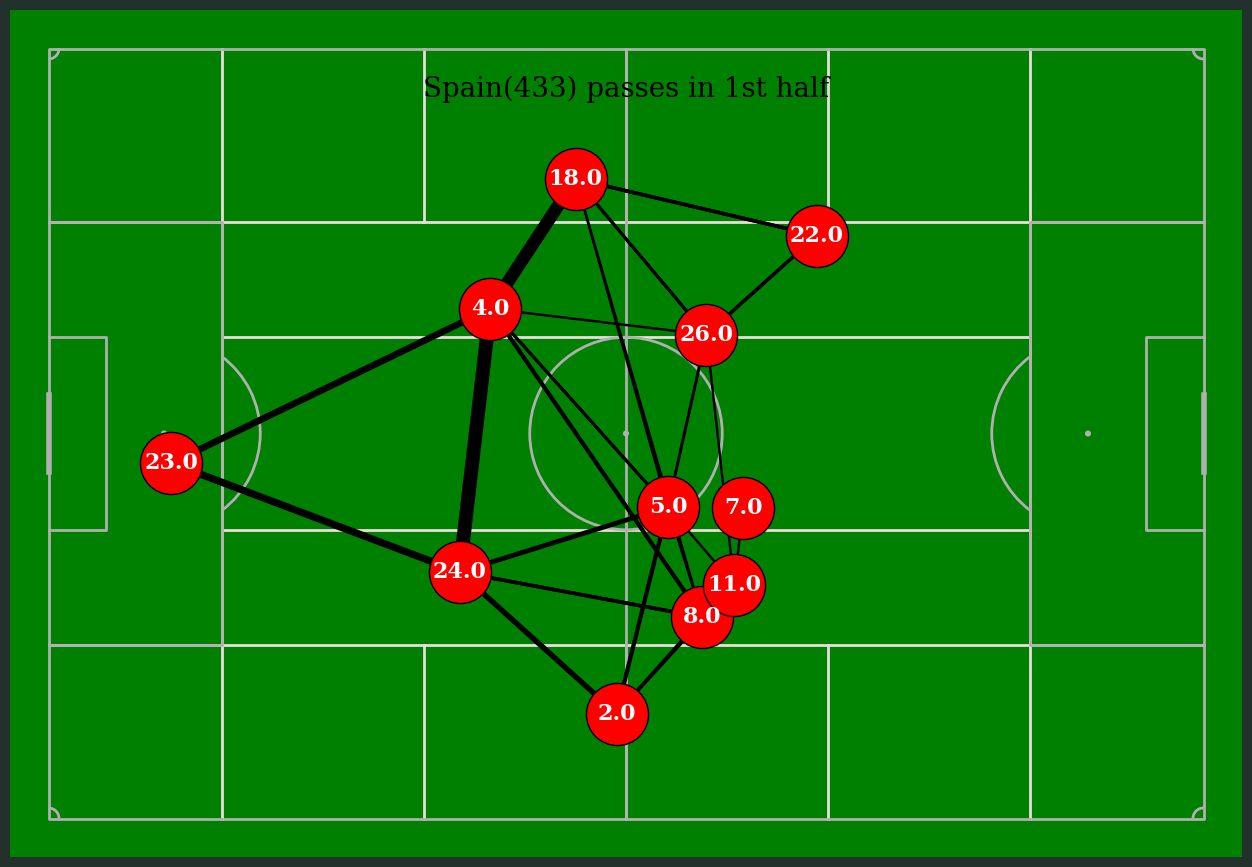

In [7]:
# standard weighted
pass_between['width'] = (pass_between['pass_count'] / pass_between['pass_count'].max()* 10)

# Replace 'average_locs_and_count' with your dataframe containing count data.
average_locations['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max()* 10 )


MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
annotation = ax.annotate('Spain(433) passes in 1st half', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")


pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)





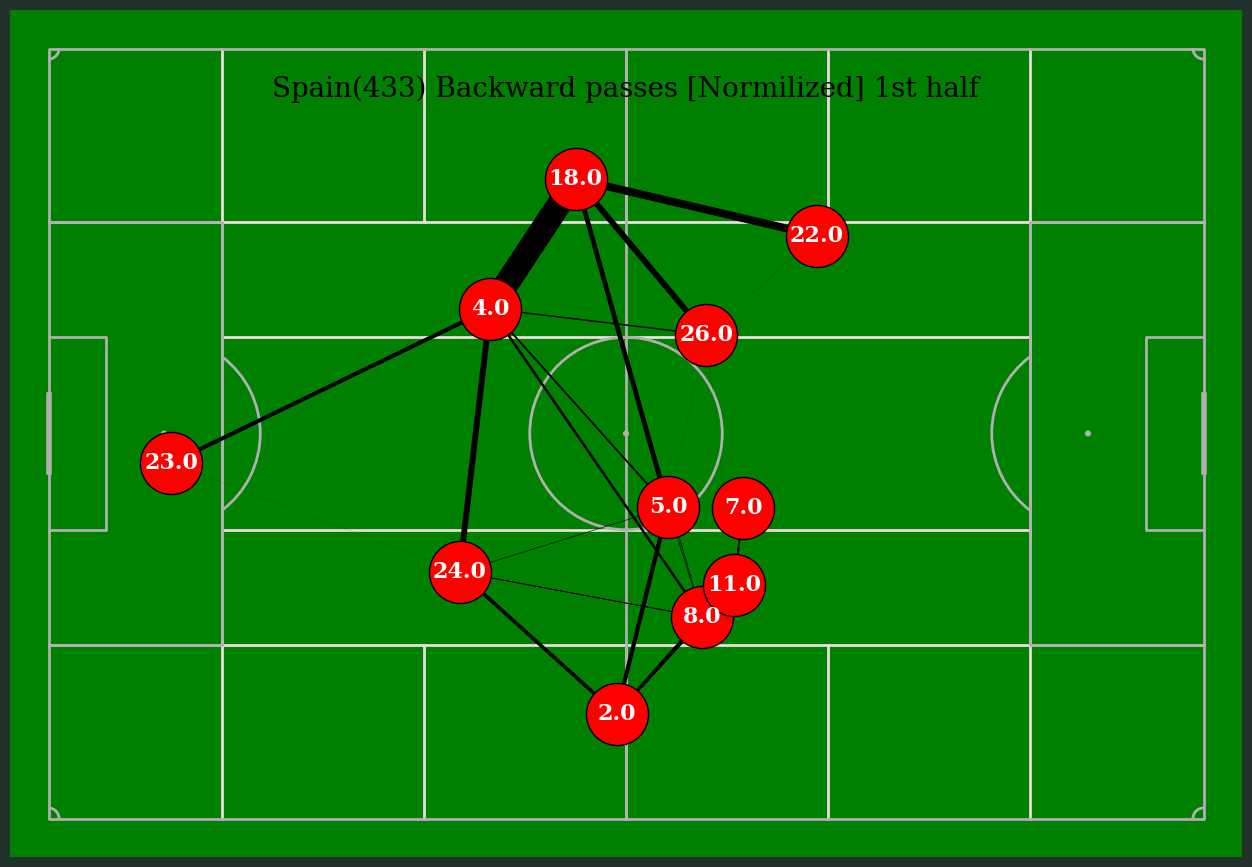

In [8]:
# backwords passing weighted.
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] + 1)) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.angle / pass_between.angle.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
annotation = ax.annotate('Spain(433) Backward passes [Normilized] 1st half', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

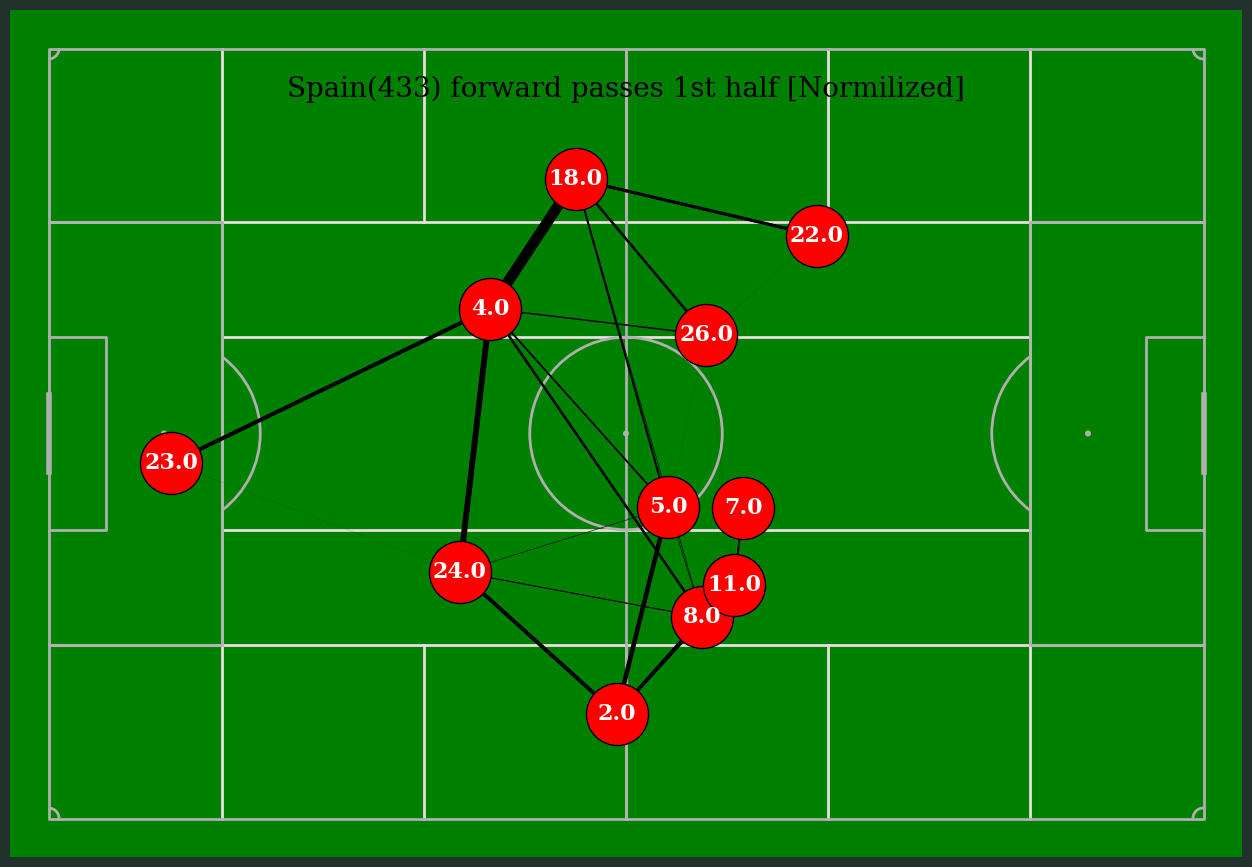

In [9]:
#forward weighted passes
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] - 1)) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

#setting details per the pitch function
pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) forward passes 1st half [Normilized]', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

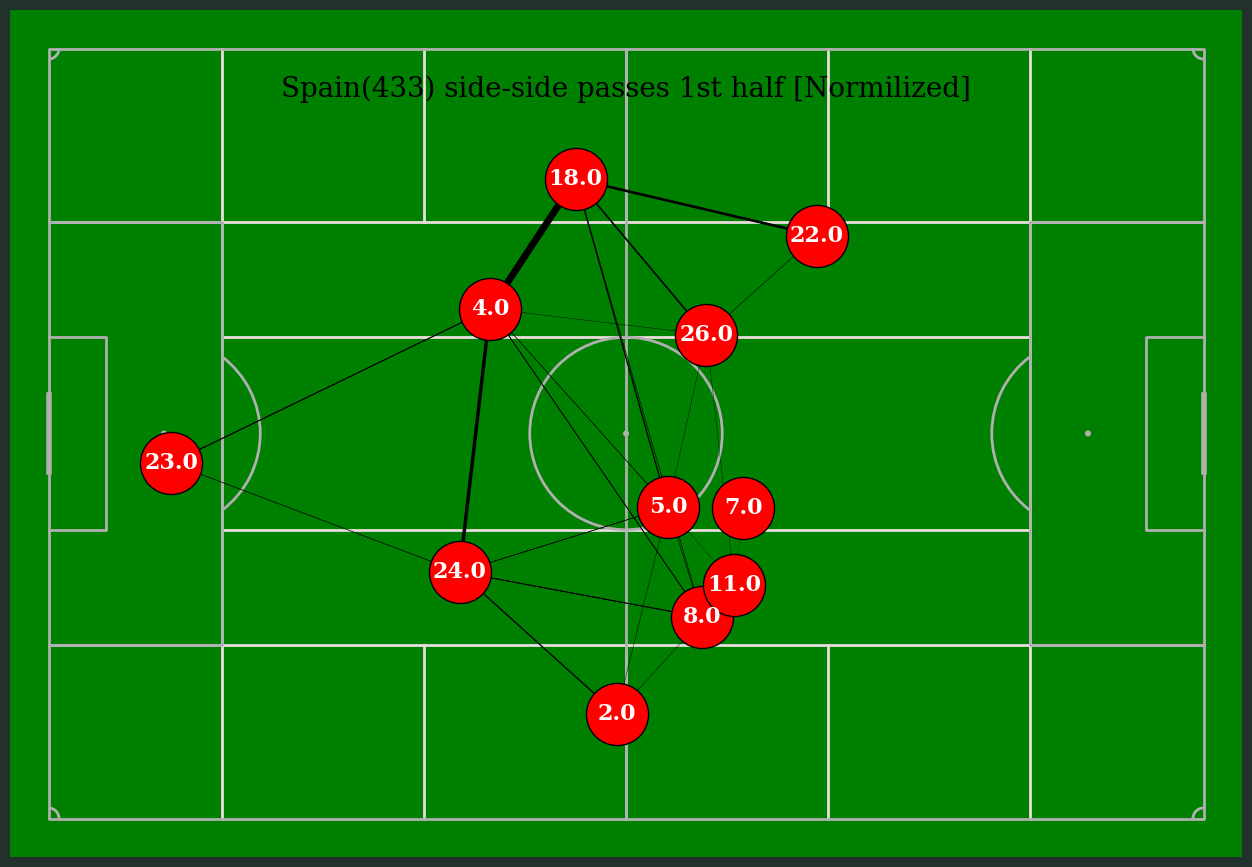

In [10]:
#side to side passes
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'])) * 10


MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) side-side passes 1st half [Normilized]', (60, 5), fontsize=20, ha='center')

fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)


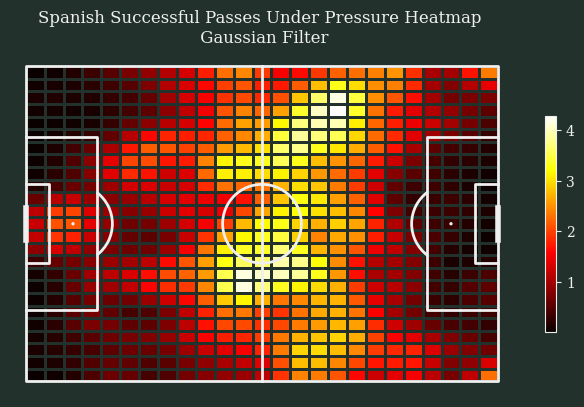

In [11]:
# filter spain pressure and pass events
pressure_passes = spain_df[(spain_df['type'] == 'Pass') & (spain_df['under_pressure'] == True) & (spain_df['period'] == 1)][['location_x', 'location_y']]


# assuming 'passes' is your original DataFrame
successful_pressure_passes = passes[passes['pass_outcome'] == 'Good']

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')

# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(successful_pressure_passes.location_x, successful_pressure_passes.location_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# Add title
plt.title('Spanish Successful Passes Under Pressure Heatmap \n Gaussian Filter', color='#efefef')
plt.show()


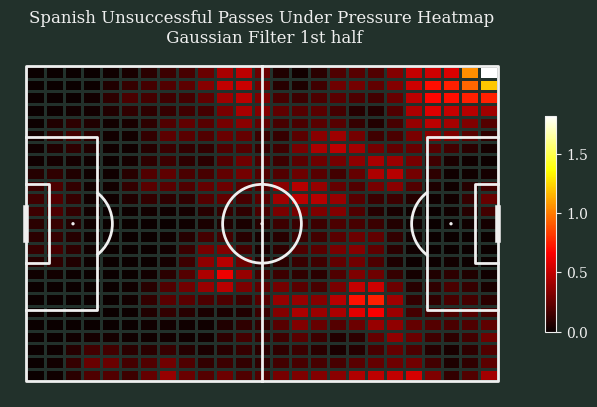

In [12]:
# filter spain pressure and pass events
pressure_passes = spain_df[(spain_df['type'] == 'Pass') & (spain_df['under_pressure'] == True) & (spain_df['period'] == 1)][['location_x', 'location_y']]


# assuming 'passes' is your original DataFrame
successful_pressure_passes = passes[passes['pass_outcome'] != 'Good']

# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')

# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(successful_pressure_passes.location_x, successful_pressure_passes.location_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# Add title
plt.title('Spanish Unsuccessful Passes Under Pressure Heatmap\n Gaussian Filter 1st half', color='#efefef')
plt.show()


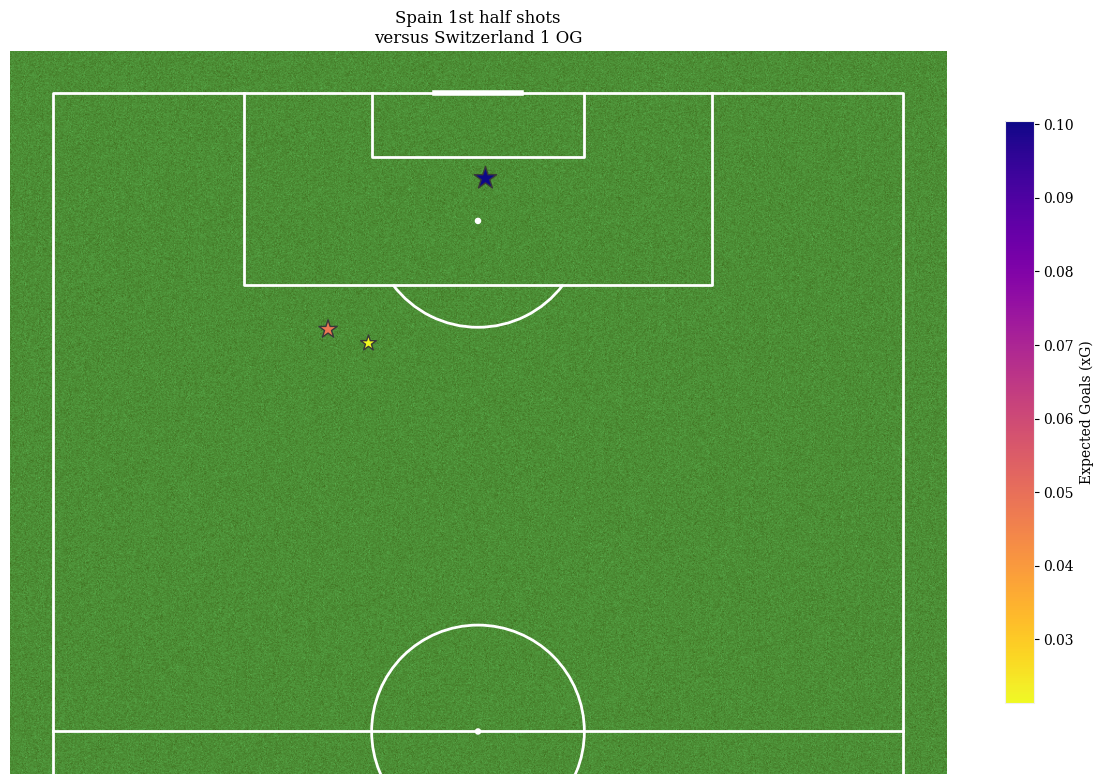

In [13]:
# Spainish shot map
spain_shot_df = spain_df[(spain_df['type'] == 'Shot') & (spain_df['period'] == 1)]


# Set up the pitch
pitch = VerticalPitch(pitch_color='grass', line_color='white',half=True)
fig, ax = pitch.draw(figsize=(12, 10))

# Scatter plot
sc = pitch.scatter(spain_shot_df.location_x, spain_shot_df.location_y,
                   s=(spain_shot_df.shot_statsbomb_xg * 1900) + 100,
                   cmap='plasma_r',
                   edgecolors='#383838',
                   c=spain_shot_df.shot_statsbomb_xg,
                   marker='*',
                   ax=ax)

# Add a title with two lines, rotated vertically
plt.title('Spain 1st half shots\nversus Switzerland 1 OG', color='black')

# Add the colorbar and format off-white, including the outline
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='black')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
cbar.set_label('Expected Goals (xG)', color='black')
plt.show()


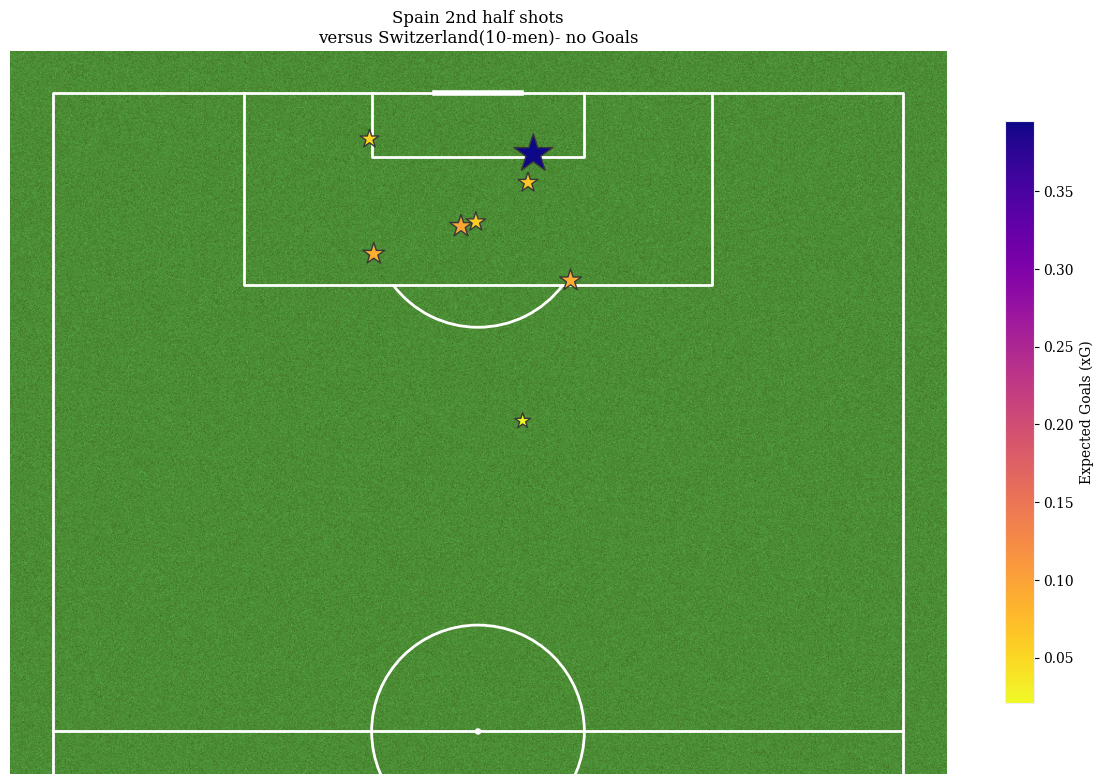

In [14]:
# Spainish shot map
spain_shot_df = spain_df[(spain_df['type'] == 'Shot') & (spain_df['period'] == 2)]


# Set up the pitch
pitch = VerticalPitch(pitch_color='grass', line_color='white',half=True)
fig, ax = pitch.draw(figsize=(12, 10))

# Scatter plot
sc = pitch.scatter(spain_shot_df.location_x, spain_shot_df.location_y,
                   s=(spain_shot_df.shot_statsbomb_xg * 1900) + 100,
                   cmap='plasma_r',
                   edgecolors='#383838',
                   c=spain_shot_df.shot_statsbomb_xg,
                   marker='*',
                   ax=ax)

# Add a title with two lines, rotated vertically
plt.title('Spain 2nd half shots\nversus Switzerland(10-men)- no Goals', color='black')

# Add the colorbar and format off-white, including the outline
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='black')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
cbar.set_label('Expected Goals (xG)', color='black')
plt.show()


In [15]:
# Filter for only passes that connected with another Spain player
passes = spain_df[spain_df['type'] == 'Pass']
successful_passes = passes[passes['pass_outcome'] == 'Good']

#77 minute until end of regular time
successful_passes = successful_passes[(successful_passes['minute'] >= 77) & (successful_passes['minute'] <= 91)]

# Now we need to find the average locations and counts of the passes
average_locations = successful_passes.groupby('passer').agg({'location_x':['mean'],'pass_angle':['mean'],'location_y':['mean','count']})
average_locations.columns = ['x','angle','y','count']

#now we need to find the average locations and counts of the passes
average_locations = successful_passes.groupby('passer').agg({'location_x':['mean'],'pass_angle':['mean'],'location_y':['mean','count']})
average_locations.columns = ['x','angle','y','count']

#now we need to find the number of passes between each player
pass_between = successful_passes.groupby(['passer','recipient']).id.count().reset_index()
pass_between.rename({'id':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

#set minimum threshold of combinationsI have seen a range of 2-5 as Spain is a pass heavy team I opted for 4
pass_between = pass_between[pass_between['pass_count'] > 3]

#Build a normilization for passes for secondary analysis
max_pass_count = pass_between['pass_count'].max()

# Normalize 'pass_count' column
pass_between['normalized_pass_count'] = pass_between['pass_count'] / max_pass_count


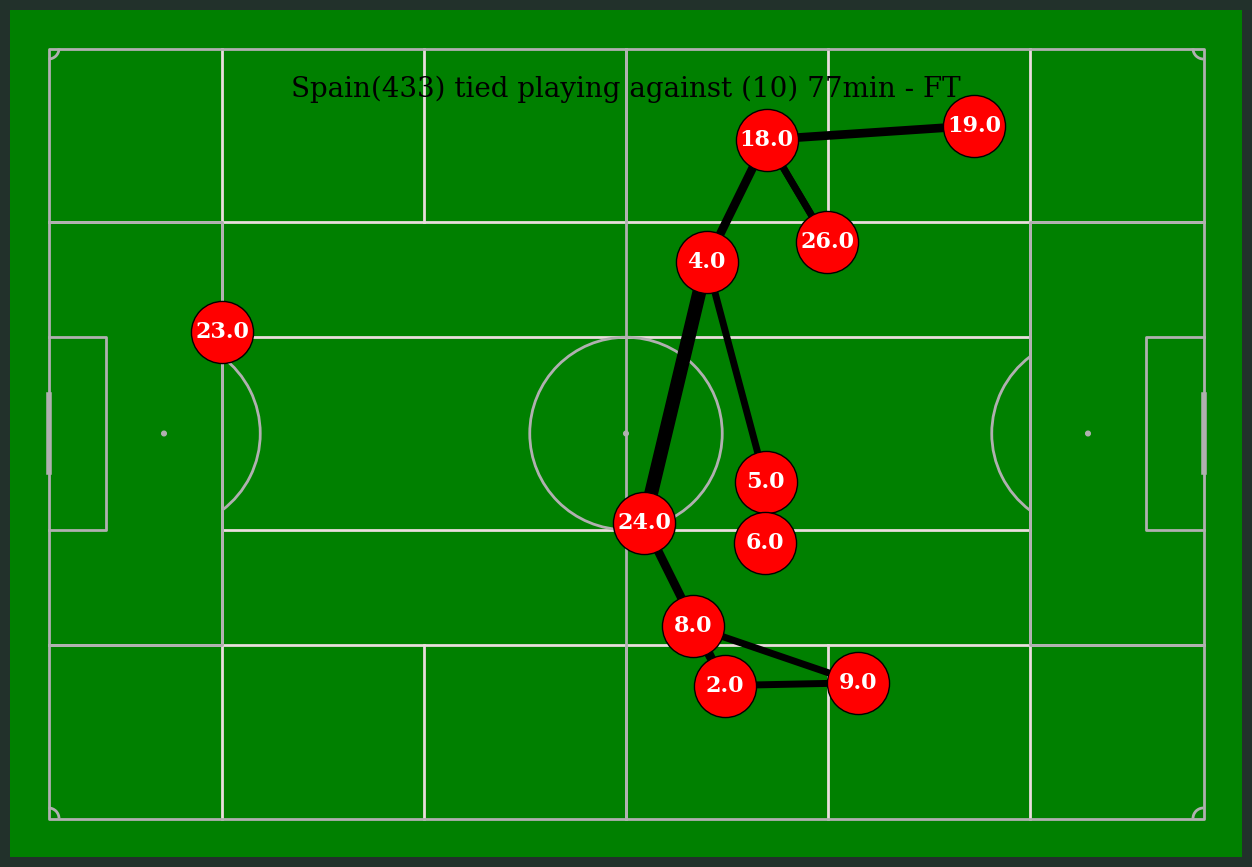

In [16]:
# standard weighted tied against 10 men
pass_between['width'] = (pass_between['pass_count'] / pass_between['pass_count'].max()* 10)

average_locations = average_locations[average_locations.index != 21.0]

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
annotation = ax.annotate('Spain(433) tied playing against (10) 77min - FT', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")


pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)




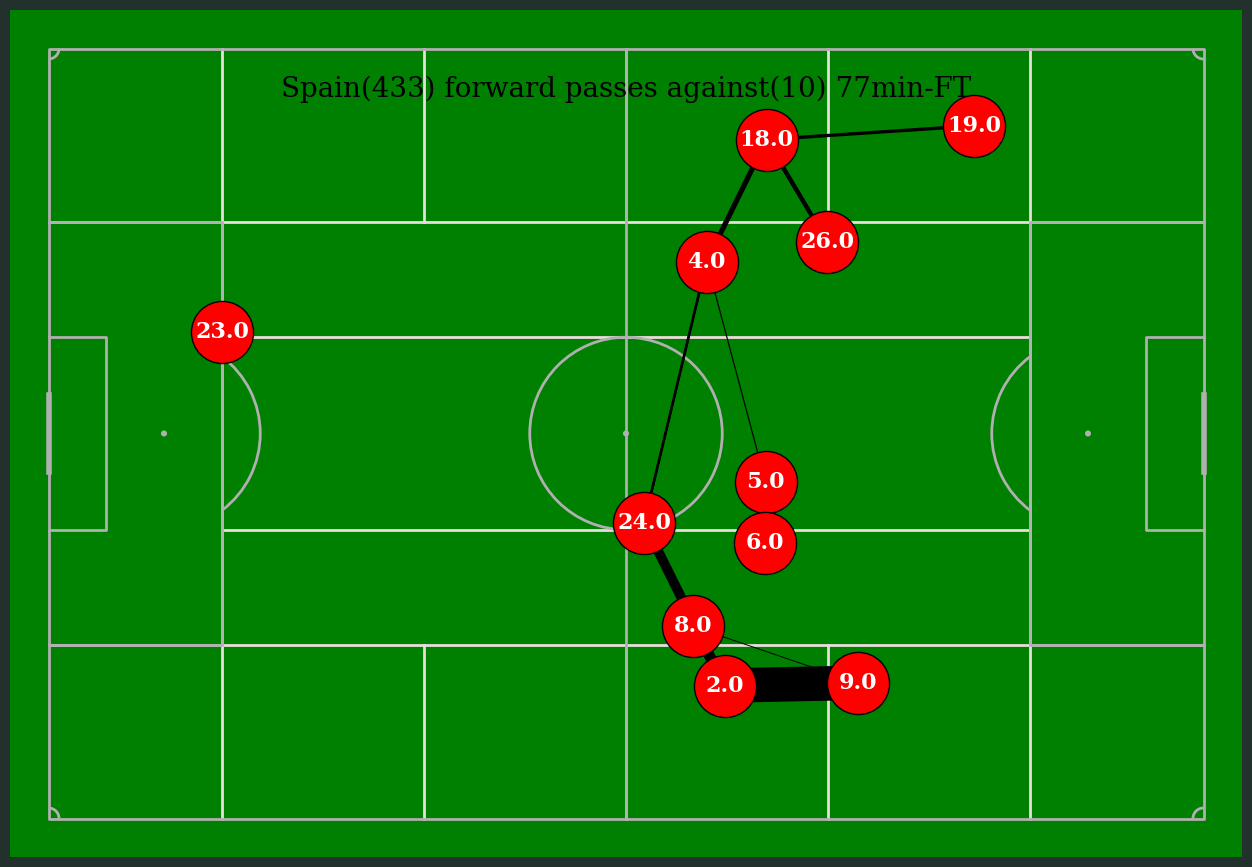

In [17]:
#forward weighted passes tied with advantage
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] - 1)) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

#setting details per the pitch function
pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) forward passes against(10) 77min-FT', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

average_locations = average_locations[average_locations.index != 21.0]

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

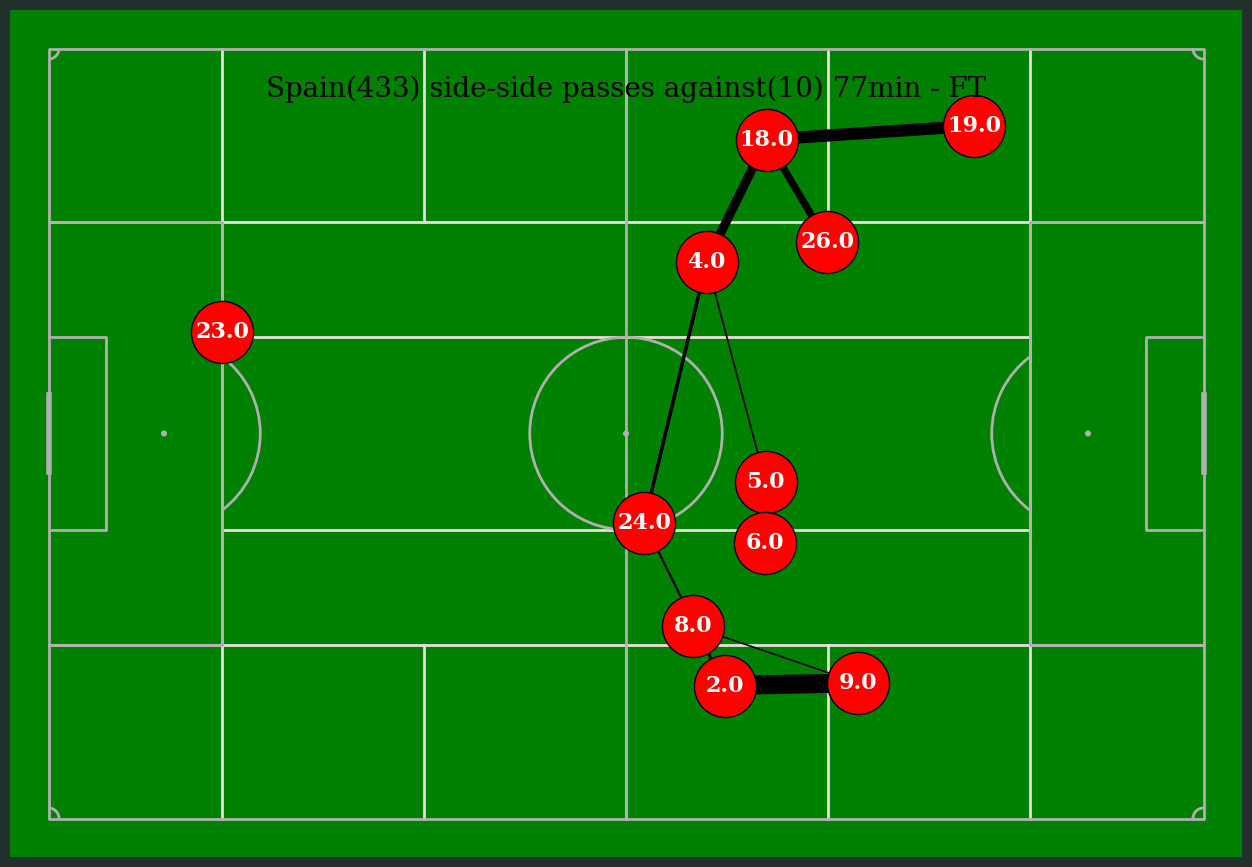

In [18]:
#side to side passes
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'])) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) side-side passes against(10) 77min - FT', (60, 5), fontsize=20, ha='center')

fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

average_locations = average_locations[average_locations.index != 21.0]

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)


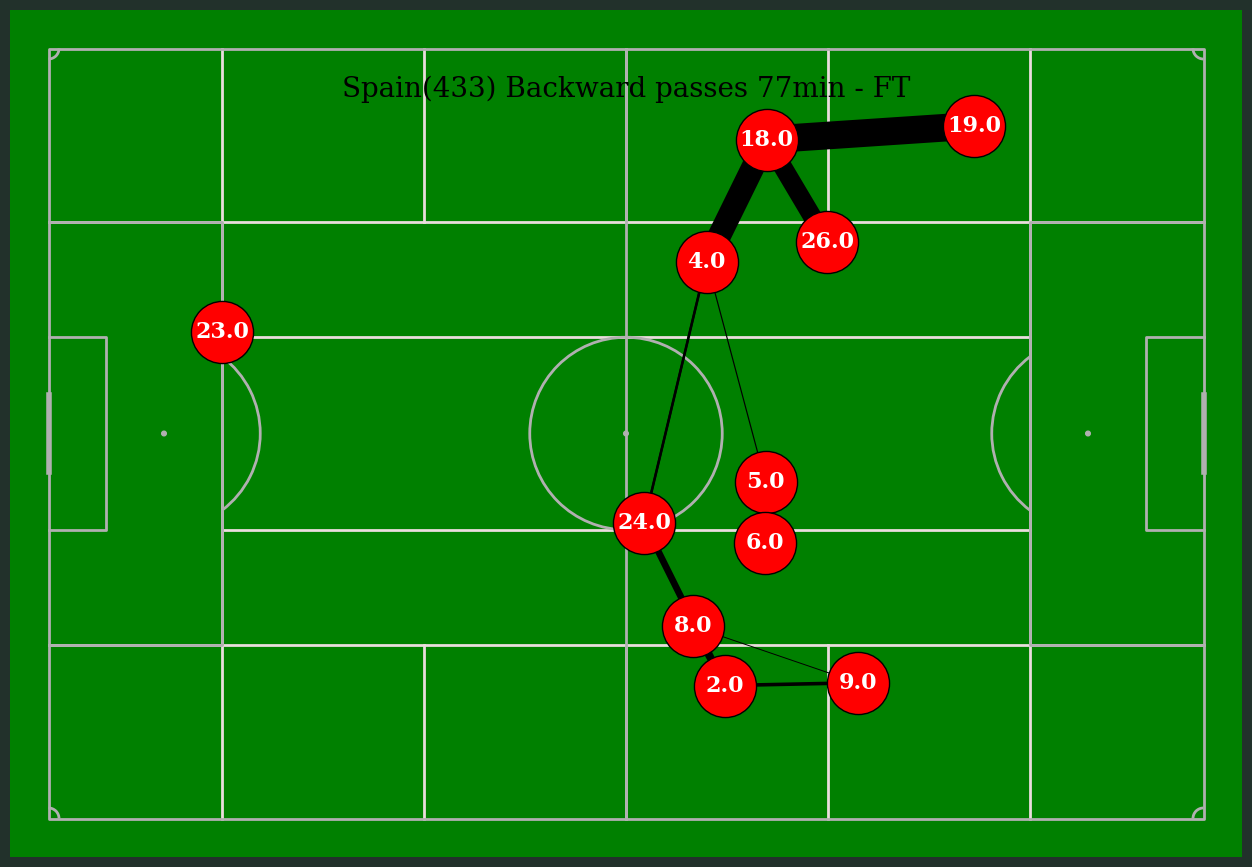

In [19]:
# backwords passing weighted.
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] + 1)) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.angle / pass_between.angle.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) Backward passes 77min - FT', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

average_locations = average_locations[average_locations.index != 21.0]

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

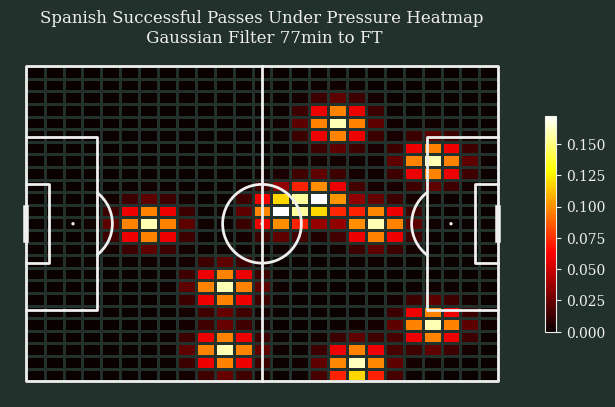

In [20]:
successful_pressure_passes_p2 = spain_df[(spain_df['type'] == 'Pass') &
                           (spain_df['under_pressure'] == True) &
                           (spain_df['pass_outcome'] == 'Good') &
                           (spain_df['minute'] >= 77) &
                           (spain_df['minute'] <= 91)][['location_x', 'location_y']]


# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')

# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(successful_pressure_passes_p2.location_x, successful_pressure_passes_p2.location_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# Add title
plt.title('Spanish Successful Passes Under Pressure Heatmap\n Gaussian Filter 77min to FT', color='#efefef')
plt.show()

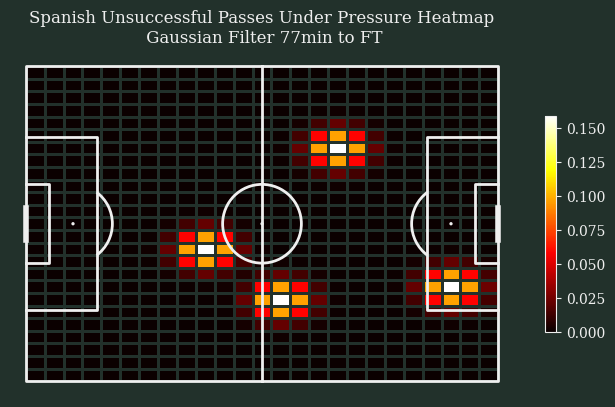

In [21]:
unsuccessful_pressure_passes_p2 = spain_df[(spain_df['type'] == 'Pass') &
                           (spain_df['under_pressure'] == True) &
                           (spain_df['pass_outcome'] != 'Good') &
                           (spain_df['minute'] >= 77) &
                           (spain_df['minute'] <= 91)][['location_x', 'location_y']]


# setup pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')

# draw
fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(unsuccessful_pressure_passes_p2.location_x, unsuccessful_pressure_passes_p2.location_y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# Add title
plt.title('Spanish Unsuccessful Passes Under Pressure Heatmap\n Gaussian Filter 77min to FT', color='#efefef')
plt.show()

interactive(children=(IntSlider(value=77, description='Start Minute:', max=120), IntSlider(value=91, descripti…

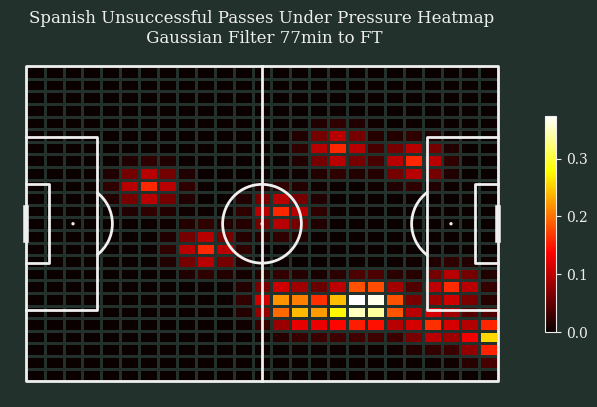

In [22]:
import ipywidgets as widgets
from ipywidgets import interact

# Function to update the plot based on time controls
def update_plot(minute_start, minute_end):
    unsuccessful_pressure_passes_p2 = spain_df[(spain_df['type'] == 'Pass') &
                                   #(spain_df['under_pressure'] == True) &
                                   (spain_df['pass_outcome'] != 'Good') &
                                   (spain_df['minute'] >= minute_start) &
                                   (spain_df['minute'] <= minute_end)][['location_x', 'location_y']]

    # setup pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
                pitch_color='#22312b', line_color='#efefef')

      # draw
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    bin_statistic = pitch.bin_statistic(unsuccessful_pressure_passes_p2.location_x, unsuccessful_pressure_passes_p2.location_y, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
    # Add title
    plt.title('Spanish Unsuccessful Passes Under Pressure Heatmap\n Gaussian Filter 77min to FT', color='#efefef')
    plt.show()

# Create interactive controls
minute_start_slider = widgets.IntSlider(value=77, min=0, max=120, step=1, description='Start Minute:')
minute_end_slider = widgets.IntSlider(value=91, min=0, max=120, step=1, description='End Minute:')

# Use interact to update the plot based on the sliders
interact(update_plot, minute_start=minute_start_slider, minute_end=minute_end_slider)

# Initial plot
update_plot(minute_start_slider.value, minute_end_slider.value)


In [23]:
#making a cross good/ bad pass map
crosses_spain = spain_df[['location_x', 'location_y', 'pass_end_location_x',
       'pass_end_location_y','pass_switch','pass_cross','period','pass_outcome','pass_through_ball']]

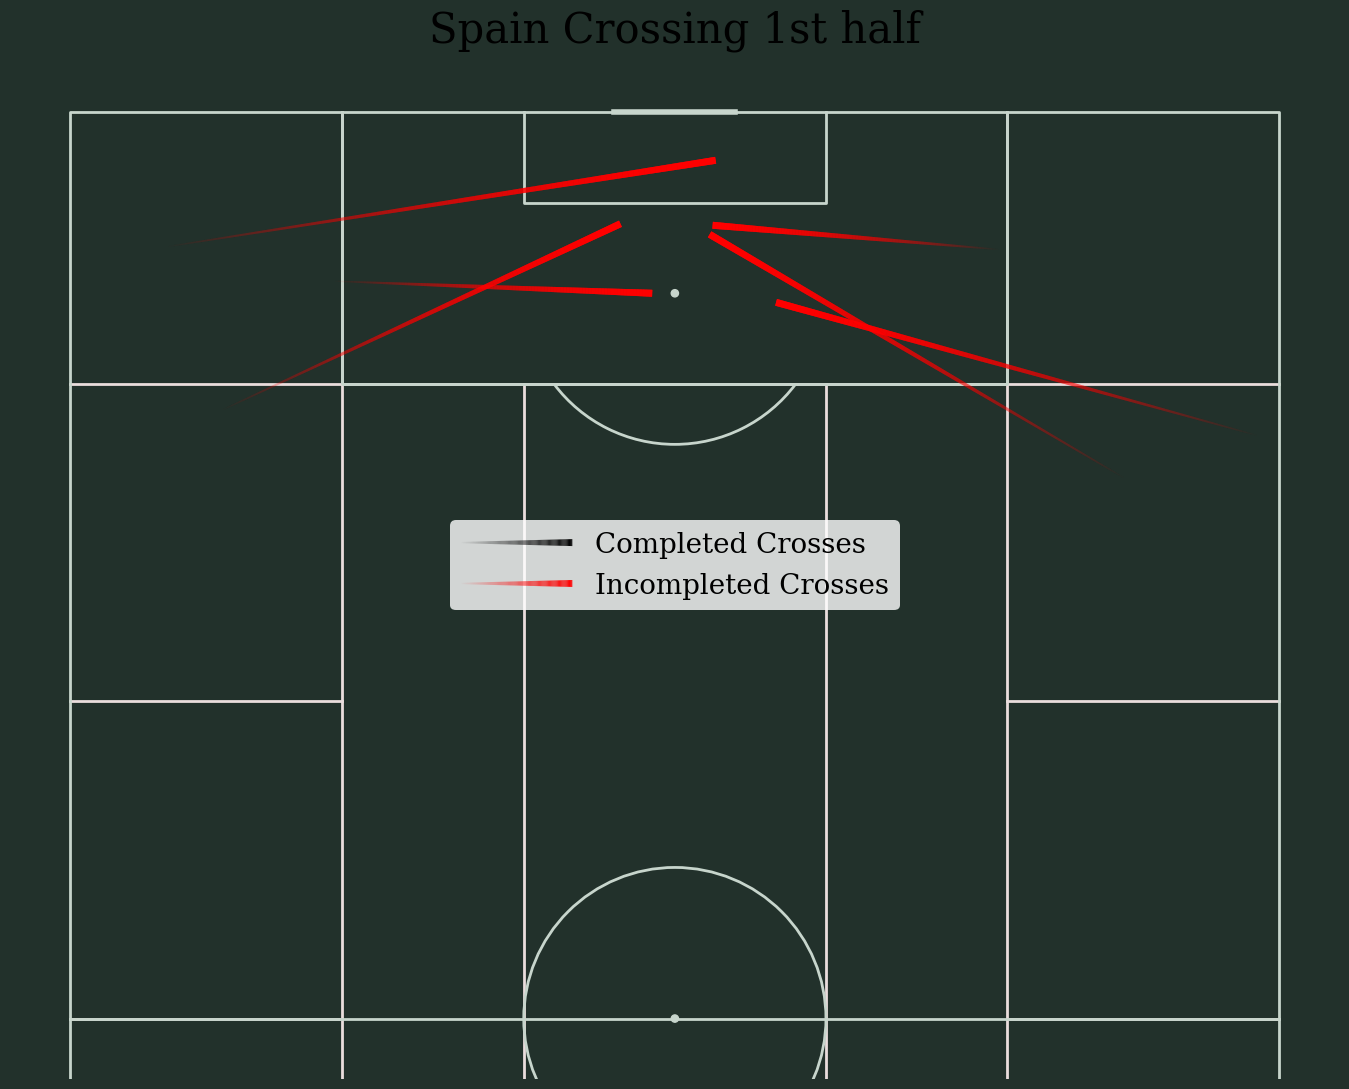

In [24]:
# Setup the pitch
pitch = VerticalPitch(positional=True, half=True, pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Set the 'period' column to 1 for completed passes
good_crosses_spain = crosses_spain[(crosses_spain['pass_cross'] == True) & (crosses_spain['pass_outcome'] == True) & (crosses_spain['period'] == 1)]


# Plot the completed passes
lc1 = pitch.lines(good_crosses_spain.location_x, good_crosses_spain.location_y,
                  good_crosses_spain.pass_end_location_x, good_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Completed Crosses',
                  color='black', ax=ax)

# Set the 'period' column to 1 for completed passes
bad_crosses_spain = crosses_spain[(crosses_spain['pass_cross'] == True) & (crosses_spain['pass_outcome'] != 'Good') & (crosses_spain['period'] == 1)]


# Plot the incompleted passes
lc2 = pitch.lines(bad_crosses_spain.location_x, bad_crosses_spain.location_y,
                  bad_crosses_spain.pass_end_location_x, bad_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Incompleted Crosses ',
                  color='red', ax=ax)


# Plot the legend
ax.legend([lc1, lc2], ['Completed Crosses', 'Incompleted Crosses'],
          facecolor='white', edgecolor='None', fontsize=20, loc='center', handlelength=4)
# Set the title
ax_title = ax.set_title(f'Spain Crossing 1st half', fontsize=30,)

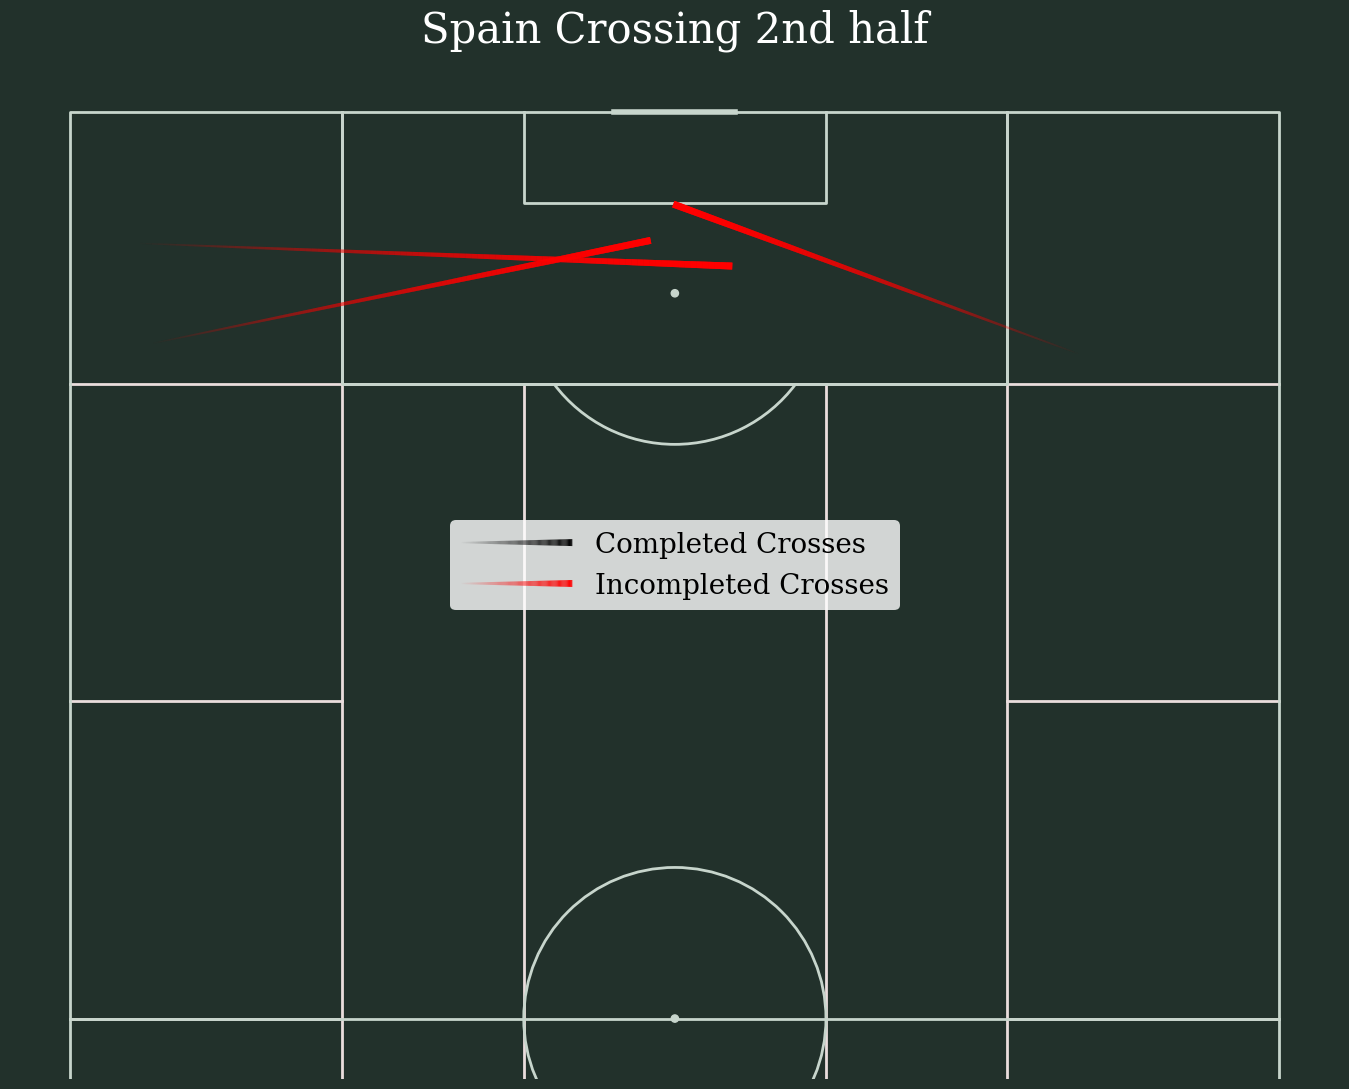

In [25]:
# Setup the pitch
pitch = VerticalPitch(positional=True, half=True, pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Set the 'period' column to 1 for completed passes
good_crosses_spain = crosses_spain[(crosses_spain['pass_cross'] == True) & (crosses_spain['pass_outcome'] == True) & (crosses_spain['period'] == 2)]


# Plot the completed passes
lc1 = pitch.lines(good_crosses_spain.location_x, good_crosses_spain.location_y,
                  good_crosses_spain.pass_end_location_x, good_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Completed Crosses',
                  color='black', ax=ax)

# Set the 'period' column to 1 for completed passes
bad_crosses_spain = crosses_spain[(crosses_spain['pass_cross'] == True) & (crosses_spain['pass_outcome'] != 'Good') & (crosses_spain['period'] == 2)]


# Plot the incompleted passes
lc2 = pitch.lines(bad_crosses_spain.location_x, bad_crosses_spain.location_y,
                  bad_crosses_spain.pass_end_location_x, bad_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Incompleted Crosses ',
                  color='red', ax=ax)


# Plot the legend
ax.legend([lc1, lc2], ['Completed Crosses', 'Incompleted Crosses'],
          facecolor='white', edgecolor='None', fontsize=20, loc='center', handlelength=4)
# Set the title
ax_title = ax.set_title(f'Spain Crossing 2nd half', fontsize=30, color='white')

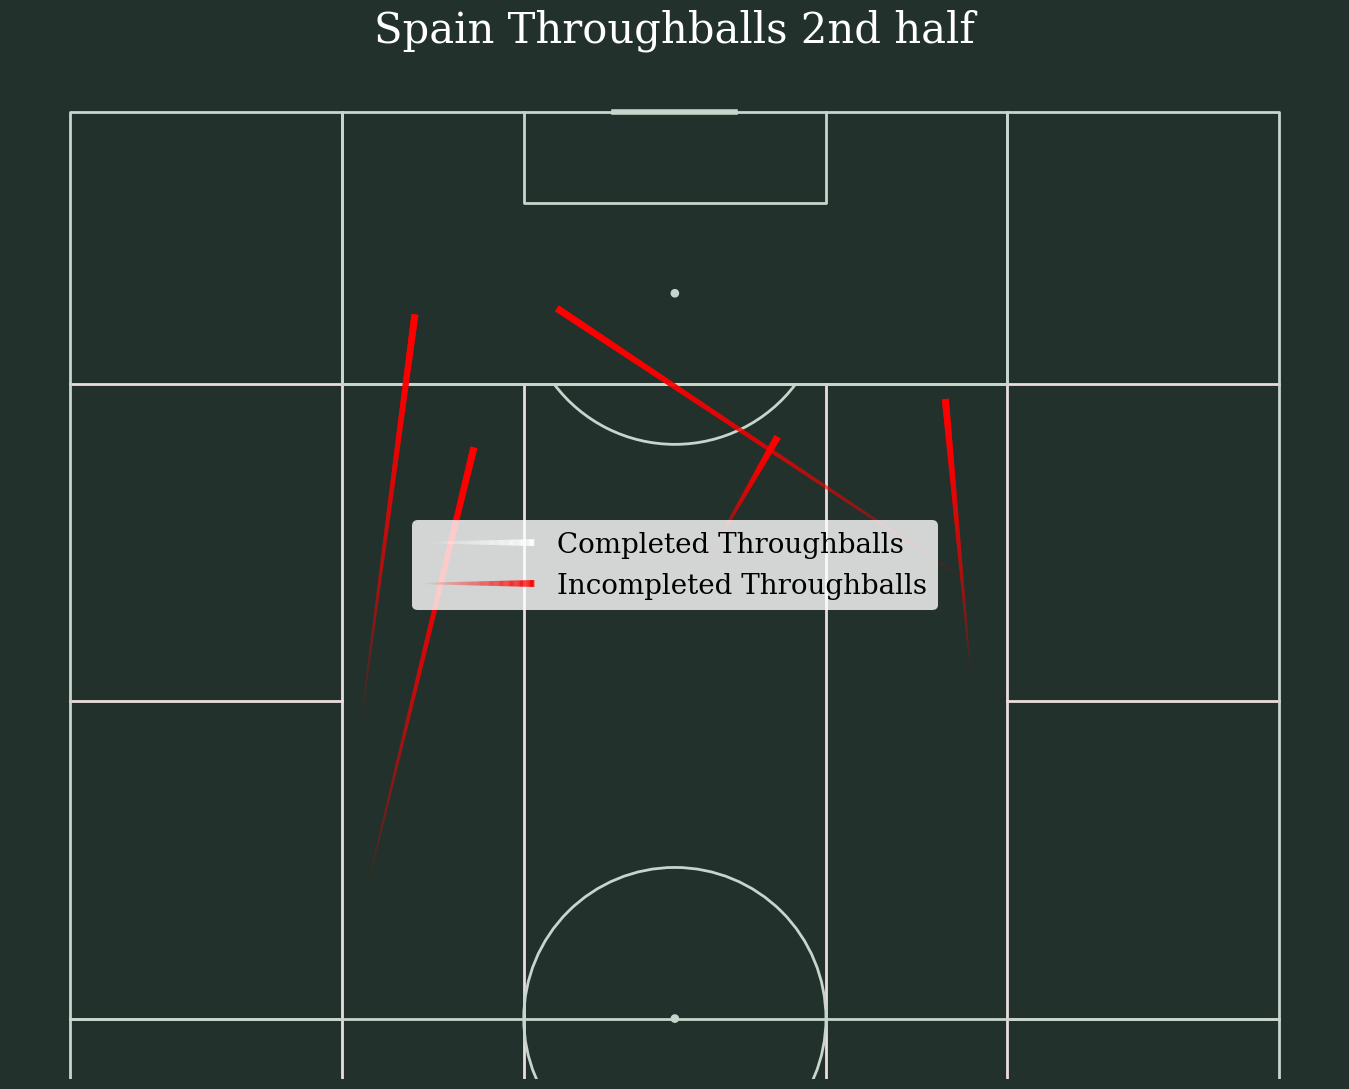

In [26]:
# Setup the pitch
pitch = VerticalPitch(positional=True, half=True, pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Set the 'period' column to 1 for completed passes
good_crosses_spain = crosses_spain[(crosses_spain['pass_through_ball'] == True) & (crosses_spain['pass_outcome'] == True) & (crosses_spain['period'] == 2)]


# Plot the completed passes
lc1 = pitch.lines(good_crosses_spain.location_x, good_crosses_spain.location_y,
                  good_crosses_spain.pass_end_location_x, good_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Completed Throughballs',
                  color='white', ax=ax)

# Set the 'period' column to 1 for completed passes
bad_crosses_spain = crosses_spain[(crosses_spain['pass_through_ball'] == True) & (crosses_spain['pass_outcome'] != 'Good') & (crosses_spain['period'] == 2)]


# Plot the incompleted passes
lc2 = pitch.lines(bad_crosses_spain.location_x, bad_crosses_spain.location_y,
                  bad_crosses_spain.pass_end_location_x, bad_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Incompleted Throughballs',
                  color='red', ax=ax)


# Plot the legend
ax.legend([lc1, lc2], ['Completed Throughballs', 'Incompleted Throughballs'],
          facecolor='white', edgecolor='None', fontsize=20, loc='center', handlelength=4)
# Set the title
ax_title = ax.set_title(f'Spain Throughballs 2nd half', fontsize=30, color='white')

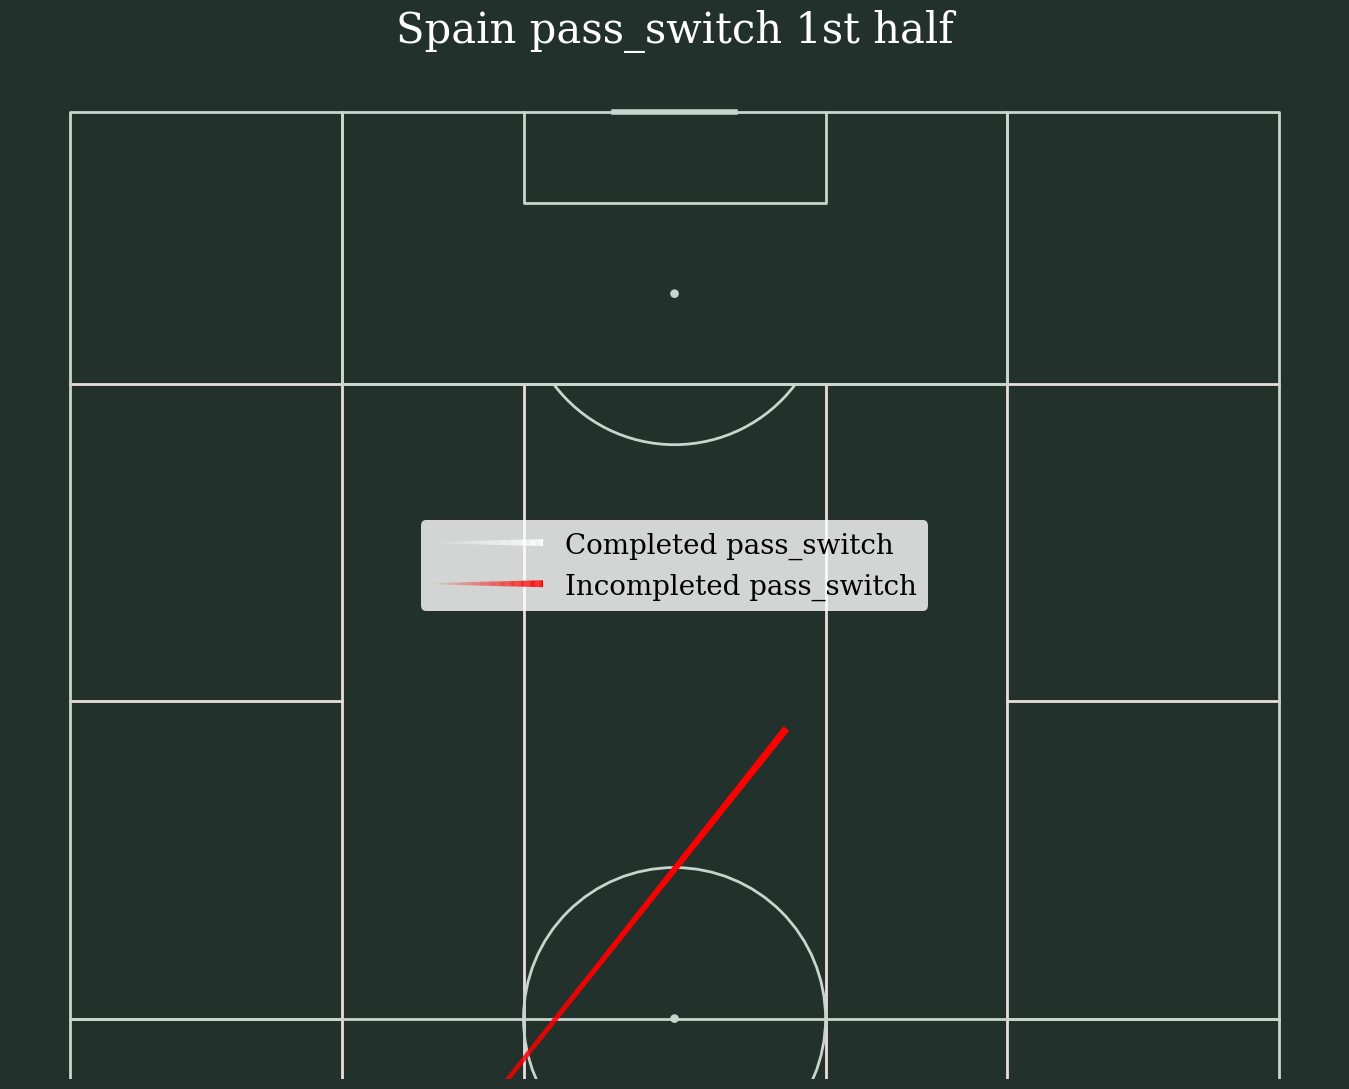

In [27]:
# Setup the pitch
pitch = VerticalPitch(positional=True, half=True, pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

# Set the 'period' column to 1 for completed passes
good_crosses_spain = crosses_spain[(crosses_spain['pass_switch'] == True) & (crosses_spain['pass_outcome'] == True) & (crosses_spain['period'] == 2)]


# Plot the completed passes
lc1 = pitch.lines(good_crosses_spain.location_x, good_crosses_spain.location_y,
                  good_crosses_spain.pass_end_location_x, good_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Completed pass_switch',
                  color='white', ax=ax)

# Set the 'period' column to 1 for completed passes
bad_crosses_spain = crosses_spain[(crosses_spain['pass_switch'] == True) & (crosses_spain['pass_outcome'] != 'Good') & (crosses_spain['period'] == 2)]


# Plot the incompleted passes
lc2 = pitch.lines(bad_crosses_spain.location_x, bad_crosses_spain.location_y,
                  bad_crosses_spain.pass_end_location_x, bad_crosses_spain.pass_end_location_y,
                  lw=5, transparent=True, comet=True, label='Incompleted pass_switch',
                  color='red', ax=ax)


# Plot the legend
ax.legend([lc1, lc2], ['Completed pass_switch', 'Incompleted pass_switch'],
          facecolor='white', edgecolor='None', fontsize=20, loc='center', handlelength=4)
# Set the title
ax_title = ax.set_title(f'Spain pass_switch 1st half', fontsize=30, color='white')